# Overview

This notebook deals with the preprocessing of the data to put it into a suitable format for later analysis and model building. In addition to the processing steps, it also contains some additional lines of code as well as comments, which should make the derivation of some transformations a little clearer. The actual preprocessing is again in a more compact form in preprocessing.py. The following steps are performed during the course of this notebook.

- [Evaluate Contract Type](#evaluate_contract_type)
- [Evaluate Work Type](#evaluate_work_type)
- [Evaluate Job Title](#evaluate_job_title)
- [Evaluate Salary](#evaluate_salary)
- [Evaluate Location](#evaluate_location)
- [Evaluate Industry](#evaluate_industry)
- [Evaluate Company Size](#evaluate_company_size)
- [Evaluate Content](#evaluate_content)

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import re

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joach\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
data_raw = pd.read_csv("../data/data_raw.csv")
data_raw.shape

(3761, 14)

In [3]:
data_raw.head()

,link,company,title,location,content,industry,rating,num_ratings,company_link,release_date,salary,company_size,contract_type,work_type
0,https://www.stepstone.de/stellenangebote--Anal...,BearingPoint GmbH,Analyst Data Science & Artificial Intelligence...,"Walldorf, Stuttgart, München, Leipzig, Hamburg...",Design your own career.Make your point @ Beari...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-06-03,NaN,2501-5000,Feste Anstellung,"Vollzeit, Home Office möglich"
1,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,Berlin,Direkter geht Karriere nicht.Einstieg bei der ...,NaN,4.3,16 Bewertungen,NaN,2022-06-03,51.000 - 68.000 €,NaN,Feste Anstellung,"Vollzeit, Home Office möglich"
2,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,"Dortmund, Düsseldorf, Aachen",Direkter geht Karriere nicht.Einstieg bei der ...,NaN,4.3,16 Bewertungen,NaN,2022-06-03,51.000 - 74.000 €,NaN,Feste Anstellung,"Vollzeit, Home Office möglich"
3,https://www.stepstone.de/stellenangebote--Data...,METRO Markets GmbH,Data Science Lead,"Düsseldorf, Palma de Mallorca",We create the future of B2B commerce by giving...,IT & Internet,NaN,NaN,NaN,2022-06-01,74.000 - 98.000 €,NaN,Feste Anstellung,"Vollzeit, Home Office möglich"
4,https://www.stepstone.de/stellenangebote--Werk...,CHECK24,Werkstudent BI und Data Science Manager (m/w/d...,München,"Bist Du bereit, etwas zu bewegen und neue, spa...",Finanzdienstleister|Versicherungen,4.5,179 Bewertungen,https://www.stepstone.de/cmp/de/CHECK24-112642...,2022-06-01,NaN,2501-5000,"Studentenjobs, Werkstudent",Teilzeit


In [4]:
data_raw.isnull().sum()

link                0
company             0
title               0
location            0
content             0
industry          637
rating           1137
num_ratings      1137
company_link      751
release_date        0
salary           1643
company_size      974
contract_type       0
work_type           0
dtype: int64

<a id="evaluate_contract_type"></a>

# Evaluate Contract Type

The job descriptions received fall into many different categories, many of which are not relevant to the analysis to come. Therefore, in this section, all irrelevant ads will be removed from the data.

In [5]:
data_raw["contract_type"].value_counts()

Feste Anstellung                                                            3218
Befristeter Vertrag                                                          151
Studentenjobs, Werkstudent                                                   117
Praktikum                                                                     95
Berufseinstieg/Trainee                                                        47
Ausbildung, Studium                                                           44
Praktikum, Studentenjobs, Werkstudent                                         28
Bachelor-/Master-/Diplom-Arbeiten                                             23
Promotion/Habilitation                                                        14
Feste Anstellung, Berufseinstieg/Trainee                                       9
Bachelor-/Master-/Diplom-Arbeiten, Praktikum                                   5
Arbeitnehmerüberlassung                                                        4
Feste Anstellung, Ausbildung

In [6]:
contracts = data_raw["contract_type"].str.replace(", ", ",").str.get_dummies(",")
contracts.sum().sort_values(ascending=False)

Feste Anstellung                     3230
Befristeter Vertrag                   151
Studentenjobs                         148
Werkstudent                           148
Praktikum                             129
Berufseinstieg/Trainee                 56
Ausbildung                             45
Studium                                45
Bachelor-/Master-/Diplom-Arbeiten      30
Promotion/Habilitation                 14
Arbeitnehmerüberlassung                 5
Freie Mitarbeit/Projektmitarbeit        1
dtype: int64

The only categories of interest in the remainder of the data analysis are "permanent employment" and "trainee".

In [7]:
def filter_contract_types(df):
    df["permanent_employment"] = df["contract_type"].str.contains("Feste Anstellung")
    df["trainee"] = df["contract_type"].str.contains("Trainee")
    df = df.loc[(df["permanent_employment"] == 1) | (df["trainee"] == 1)]
    df = df.drop("contract_type", axis=1)
    return df

data_cleaned = filter_contract_types(data_raw)
data_cleaned.shape

(3277, 15)

In [8]:
data_cleaned.columns

Index(['link', 'company', 'title', 'location', 'content', 'industry', 'rating',
       'num_ratings', 'company_link', 'release_date', 'salary', 'company_size',
       'work_type', 'permanent_employment', 'trainee'],
      dtype='object')

<a id="evaluate_work_type"></a>

# Evaluate Work Type

In [9]:
data_cleaned["work_type"].value_counts()

Vollzeit                                   1893
Vollzeit, Home Office möglich              1093
Vollzeit, Teilzeit, Home Office möglich     171
Vollzeit, Teilzeit                          107
Teilzeit                                     10
Teilzeit, Home Office möglich                 3
Name: work_type, dtype: int64

Among the job descriptions are both full-time and part-time jobs. Some of these jobs can also optionally be performed in the home office. Since the attribute "work_type" can also contain several of these categories, it is split into three individual attributes below.

In [10]:
def convert_work_types(df):
    work_types = df["work_type"].str.replace(", ", ",").str.get_dummies(",").astype("bool")
    work_types = work_types.rename({"Vollzeit": "full_time", "Teilzeit": "part_time", "Home Office möglich": "home_office_possible"}, axis=1)
    df = pd.concat([df, work_types], axis=1)
    df = df.drop("work_type", axis=1)
    return df

data_cleaned = convert_work_types(data_cleaned)
data_cleaned.shape

(3277, 17)

<a id="evaluate_job_title"></a>

# Evaluate Job Title

The problem with analyzing job titles is that they are not in a uniform format and thus almost every name is unique. Therefore, at this point we will try to divide the titles into different categories with the help of some rule.

In [11]:
data_cleaned["title"].nunique()

3041

In [12]:
data_cleaned["title"].value_counts()

Data Engineer (m/w/d)                                                            22
Data Scientist (m/w/d)                                                           18
Data Analyst (m/w/d)                                                             17
Data Engineer (w/m/d)                                                             9
Data Engineer (m/f/d)                                                             7
                                                                                 ..
Senior Sales Manager IT Solutions (m/w/d)                                         1
W2‑Professur für Industrie 4.0 / IoT / Cyberphysische Systeme (m/w/d)             1
Spezialist Global Pricing (m/w/d)                                                 1
Sensor Fusion Data Engineer C++ / Python for L4 Autonomous Driving (f/m/div.)     1
Senior Analyst im Bereich Economic Intelligence (w/m/d)                           1
Name: title, Length: 3041, dtype: int64

To get an overview of frequently occurring patterns in the job titles, all titles are combined into a single string and the occurrence of individual words and combinations of words is counted. 

In [13]:
stop_eng = set(stopwords.words('english'))
stop_ger = set(stopwords.words('german'))
stop_all = stop_eng.union(stop_ger)
len(stop_all)

405

In [14]:
# CountVectorizer actually expects several examples
title_text = " | ".join(data_cleaned["title"])
l = []
l.append(title_text)

vectorizer = CountVectorizer(ngram_range=(2,3))
vector = vectorizer.fit_transform(l)
results = pd.DataFrame({"keyword": vectorizer.get_feature_names_out(), "count": vector.toarray().reshape(-1)})
results = results.loc[~results["keyword"].isin(stop_eng.union(stop_ger))]
results.sort_values("count", ascending=False).head(20)

,keyword,count
5063,data engineer,270
4836,data analyst,204
5370,data scientist,191
18236,senior consultant,151
18301,senior data,150
7606,engineer data,106
12944,machine learning,77
19033,software engineer,75
4937,data analytics,74
3167,business intelligence,74


Based on the obtained findings, a set of rules was formed using regular expressions to classify the existing job titles into the following categories:
- Software Engineer
- Data Analyst
- Data Scientist
- Data Engineer
- Machine Learning Engineer
- Data Science Consultant
- Data Science Manager

One problem that became clear during the derivation of the rules is that the categories obtained are not exclusive. For example, some job titles contain the term "Data Analyst/Scientist". For this reason, it was decided to make the classification hierarchical and to overwrite ambiguous job titles with the superordinate category in case of doubt.

In [15]:
def convert_title(df):
    df["title_category"] = "Others"
    df.loc[df["title"].str.contains("Software|Developer|Entwickler", case=False, regex=True), "title_category"] = "Software Engineer"
    df.loc[df["title"].str.contains("Analyst|Business[- ]*Intelligence|Analytics|Reporting", case=False, regex=True), "title_category"] = "Data Analyst"
    df.loc[df["title"].str.contains("Data[ \S]*Scien|Research[ \S]*(Scientist|Engineer)|Statistik", case=False, regex=True), "title_category"] = "Data Scientist"
    df.loc[df["title"].str.contains("(Data|Cloud)[ \S]*(Engineer|Archite(c|k)t|Specialist)|Data Warehouse|Datenbank|Database", case=False, regex=True), "title_category"] = "Data Engineer"
    df.loc[df["title"].str.contains("Machine[- ]*Learning|Deep[- ]*Learning|(\W|^)(AI|KI|ML|DL)(\W|$)|Artificial[- ]*Intelligence|Künstliche[- ]*Intelligenz|MLOps", case=False, regex=True), "title_category"] = "Machine Learning Engineer"   
    df.loc[df["title"].str.contains("Consultant|Berater|Consulting", case=False, regex=True), "title_category"] = "Data Science Consultant"
    df.loc[df["title"].str.contains("Manager|Head|Lead|Leiter|Leitung|Vorstand|Chief|Owner|Partner|Director", case=False, regex=True), "title_category"] = "Data Science Manager" 
    return df

data_cleaned = convert_title(data_cleaned)
print(data_cleaned["title"].nunique())
data_cleaned["title_category"].value_counts()

3041


Data Science Manager         746
Others                       660
Data Science Consultant      401
Software Engineer            400
Data Analyst                 362
Data Engineer                358
Data Scientist               202
Machine Learning Engineer    148
Name: title_category, dtype: int64

It is clear that several job ads could not be assigned to any of the defined categories. This is due to the fact that when scraping the ads, not only exact job titles but also keywords such as "Data Science" or "Machine Learning" were searched for in order to integrate as many possible job titles as possible. However, this also included jobs where the company is oriented towards Data Science, but the actual job does not have much to do with it. Since the existing rule was used to try to capture all relevant jobs as best as possible, all other entries can be excluded from the subsequent analysis.

In [16]:
with pd.option_context("display.max_colwidth", None):
    print(data_cleaned.loc[data_cleaned["title_category"] == "Others", "title"].head(10))

133                                                        Sr. Experience Researcher, International Product Led Growth
137                                                                                            DevOps Engineer (m/w/d)
162                                                                        Referent RTL Data (w/m/d) (RTL Deutschland)
195                                                                                     Digital Health Experte (m/w/d)
202                                                                                     IT Systemadministrator (m/w/d)
203                                                                                     Mathematiker (m/w/d) Aktuariat
206    IT-Experte/IT-Spezialist/in (m/w/d)\nTelekommunikationsüberwachung und Elektronische Schnittstelle der Behörden
207            IT-Experte/IT-Spezialist/in (w/m/d)\nTelekommunikationsüberwachung / Informationstechnische Überwachung
212                                             

Furthermore, some job titles may additionally indicate the required experience level for the position.

In [17]:
def extract_experience_level(df):
    df["experience_level"] = "No Information"
    df.loc[df["title"].str.contains("Junior|Jr.", case=False), "experience_level"] = "Junior"
    df.loc[df["title"].str.contains("Senior|Sr.", case=False), "experience_level"] = "Senior"
    return df

data_cleaned = extract_experience_level(data_cleaned)
data_cleaned["experience_level"].value_counts()

No Information    2438
Senior             684
Junior             155
Name: experience_level, dtype: int64

<a id="evaluate_salary"></a>

# Evaluate Salary

In [18]:
def convert_salary(df):
    min_salaries = df["salary"].str.split(" ").str[0].str.replace(".", "", regex=False).astype("float")
    max_salaries = df["salary"].str.split(" ").str[2].str.replace(".", "", regex=False).astype("float")
    df["average_salary"] = (min_salaries + max_salaries) / 2
    df.drop("salary", axis=1, inplace=True)
    return df

data_cleaned = convert_salary(data_cleaned)
data_cleaned.shape

(3277, 19)

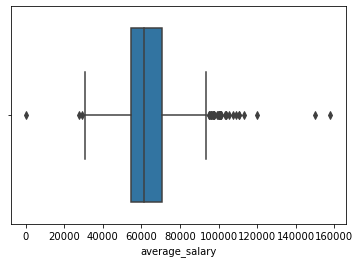

In [60]:
sns.boxplot(x=data_cleaned["average_salary"]);

When looking at the salaries, an outlier close to 0 becomes apparent, which should not really exist. A closer look at the job ad shows that the rest of the data is completely fine. Therefore, it was decided at this point to keep the ad in the data and set the salary to NaN.

In [20]:
data_cleaned.loc[data_cleaned["average_salary"]<25000]

,link,company,title,location,content,industry,rating,num_ratings,company_link,release_date,company_size,permanent_employment,trainee,home_office_possible,part_time,full_time,title_category,experience_level,average_salary
2486,https://www.stepstone.de/stellenangebote--Expe...,Home Shopping Europe GmbH,Expert (m/w/d) Operations Analytics,"Ismaning, Raum München","Zwischen Excelsheets und Live-TV, zwischen For...",IT & Internet,4.3,49 Bewertungen,https://www.stepstone.de/cmp/de/Home-Shopping-...,2022-05-25,501-1000,True,False,True,False,True,Data Analyst,No Information,1.0


In [21]:
data_cleaned.loc[data_cleaned["average_salary"]<25000, "average_salary"] = np.nan

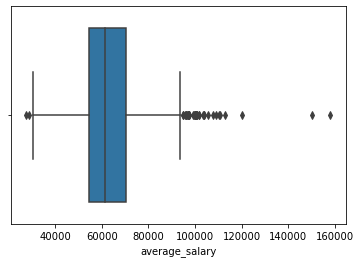

In [61]:
sns.boxplot(x=data_cleaned["average_salary"]);

There are also two outliers on the right side. However, a closer look shows that these are valid data points. Therefore, they are not removed from the data. However, when training a machine learning model later on, it may be useful to exclude them from the training data in order not to distort the learned relationships.

In [23]:
data_cleaned.loc[data_cleaned["average_salary"]>120000]

,link,company,title,location,content,industry,rating,num_ratings,company_link,release_date,company_size,permanent_employment,trainee,home_office_possible,part_time,full_time,title_category,experience_level,average_salary
1060,https://www.stepstone.de/stellenangebote--VP-G...,Evotec SE,VP Global Head Cellular Sciences (f/m/d),Hamburg,Evotec is a life science company with a uniqu...,Pharmaindustrie,3.6,5 Bewertungen,NaN,2022-06-03,NaN,True,False,False,False,True,Data Science Manager,No Information,158000.0
3124,https://www.stepstone.de/stellenangebote--Supp...,Elmar Hertzog und Partner Management Consultan...,Supply Chain Strategy Director (f/m/d),Berlin,Hertzog & Partner was founded in 1978 and sinc...,NaN,NaN,NaN,NaN,2022-06-01,NaN,True,False,False,False,True,Data Science Manager,No Information,150000.0


<a id="evaluate_location"></a>

# Evaluate Location

In this section, the geographical information of the job ads is processed. An initial overview of the data shows that there are entries for which multiple locations are specified. For a closer analysis, these entries have to be split into several lines so that each entry contains only a single location.

In [24]:
data_cleaned["location"].value_counts().head(20)

München                                                         258
Berlin                                                          252
Hamburg                                                         143
Stuttgart                                                       141
Düsseldorf                                                       92
Köln                                                             71
Frankfurt am Main                                                70
bundesweit                                                       55
Renningen                                                        36
Berlin, Frankfurt am Main, Hamburg, Köln, München, Stuttgart     32
Karlsruhe                                                        31
Heidelberg                                                       31
Frankfurt (Main)                                                 25
Essen                                                            25
Hannover                                        

In [25]:
num_words = data_cleaned["location"].str.split(",").str.len()
num_words.value_counts()

1     2304
2      235
3      146
6      123
4       89
5       82
10      82
7       73
8       63
9       54
11      25
12       1
Name: location, dtype: int64

When looking at the split values, it becomes clear that the data are not available in a uniform format. Four different spellings are available for the city "Frankfurt". In addition, terms such as "bundesweit" or "home office" need to be standardized.

In [26]:
data_cleaned["location"].str.split(", ").explode().value_counts().head(20)

München              825
Berlin               770
Hamburg              603
Stuttgart            514
Düsseldorf           415
Köln                 410
Frankfurt am Main    281
Hannover             186
Frankfurt            184
Nürnberg             157
Leipzig               99
Dortmund              94
Karlsruhe             84
bundesweit            82
Frankfurt (Main)      80
Essen                 74
Ratingen              53
Münster               49
Ludwigshafen          48
Dresden               46
Name: location, dtype: int64

In order to bring all data into a uniform format, a number of different rules are required. For the sake of clarity, all the rules received have been combined into one function here and the derivation and operation of the individual rules has been omitted.

In [27]:
# the following function extracts the individual city names using regular expressions
# the last rules are relatively individual to the used data
# ==> would have to be revised for new data possibly again

def extract_locations(df):
    locations = df["location"].str.strip(" ,")
    locations = locations.str.split(", ?").explode()
    locations = locations.str.split(" ?/ ?").explode()
    locations = locations.str.split(" oder ").explode()
    locations = locations.str.split(" und ").explode()
    locations = locations.str.split(" - ").explode()
    locations = locations.str.split("; ").explode()
    locations = locations.str.split(" ?\+ ?").explode()
    locations = locations.replace("^Raum ", "", regex=True)
    locations = locations.str.replace(" \(?(bei|b\.|an|am|a\.|ob|in|im|vor|v\.|\+|%|u\.a\.|Raum)[)\w\d .]+", "", regex=True)
    locations = locations.str.replace("[ \w-]*(Home|Office|Mobile|Remote|Bundes|Deutschland|Wahl|Standort|DACH|keine Angabe)[( \w-]*", "bundesweit", case=False, regex=True)
    locations = locations.str.replace(" ?(a\.M\.|Main|M\.|\.\.\.und weitere|Gutenbergquartier)$", "", regex=True)
    locations = locations.str.replace("(MBTI|bei|\d{5}|Metropolregion|Fürstentum|Großraum|100%) ?", "", regex=True)
    locations = locations.str.replace("St.", "Sankt", regex=False)
    locations = locations.str.replace(".", "", regex=False)
    locations = locations.str.split(" \(").explode()
    locations = locations.where(locations.str.contains("^(Bad|Sankt|Palma|New|Den|Schwäbisch|Lindau) ", regex=True), locations.str.split(" ")).explode()
    locations = locations.str.strip("[ )]")
    locations = locations.replace("^$", np.nan, regex=True)
    return locations

locs = extract_locations(data_cleaned)
# Joining via the index is possible, since this is duplicated in the explode() method
data_long = pd.merge(data_cleaned, locs, left_index=True, right_index=True, how="left", suffixes=["_x", None])
data_long = data_long.drop("location_x", axis=1)
print(data_long.index.nunique())
data_long["location"].value_counts().head(20)

3277


München         868
Berlin          802
Frankfurt       657
Hamburg         628
Stuttgart       537
Köln            436
Düsseldorf      431
bundesweit      276
Hannover        197
Nürnberg        173
Leipzig         103
Dortmund         96
Main             88
Karlsruhe        87
Essen            84
Ratingen         58
Ludwigshafen     52
Mannheim         49
Münster          49
Ulm              47
Name: location, dtype: int64

In [28]:
data_long.shape

(7548, 19)

In [29]:
data_long.to_csv("../data/data_long.csv", index=False)

For a regional analysis of the jobs, it was necessary to collect additional information. The website https://positionstack.com/ provides a free API to return the geo-coordinates to any address, as well as additional information such as country or state. In the positionstack.py code, a GET request is sent to the positionstack API for each location contained in the saved dataframe to obtain the desired information.

In [30]:
geo_data = pd.read_csv("../data/geo_data.csv")
geo_data.head()

,latitude,longitude,type,name,number,postal_code,street,confidence,region,region_code,county,locality,administrative_area,neighbourhood,country,country_code,continent,label,location
0,49.307822,8.641450,locality,Walldorf,NaN,NaN,NaN,1.0,Baden-Württemberg,BW,Rhein-Neckar-Kreis,Walldorf,Walldorf,NaN,Germany,DEU,Europe,"Walldorf, BW, Germany",Walldorf
1,48.706310,9.119240,locality,Stuttgart,NaN,NaN,NaN,1.0,Baden-Württemberg,BW,Esslingen,Stuttgart,Leinfelden-Echterdingen,NaN,Germany,DEU,Europe,"Stuttgart, BW, Germany",Stuttgart
2,48.152126,11.544467,locality,Munich,NaN,NaN,NaN,1.0,Bavaria,BY,Munich,Munich,München,NaN,Germany,DEU,Europe,"Munich, BY, Germany",München
3,51.341053,12.404024,locality,Leipzig,NaN,NaN,NaN,1.0,Saxony,SN,Leipzig,Leipzig,Leipzig,NaN,Germany,DEU,Europe,"Leipzig, SN, Germany",Leipzig
4,53.576158,10.007046,locality,Hamburg,NaN,NaN,NaN,1.0,Hamburg,HH,Hamburg,Hamburg,Hamburg,NaN,Germany,DEU,Europe,"Hamburg, Germany",Hamburg


The overview of all missing values shows that no information could be retrieved for some locations. A closer analysis shows that these are either jobs without a fixed location or locations abroad. Since this is only an analysis in Germany, these locations can be removed from the data without any problems.

In [31]:
geo_data.isnull().sum()

latitude                14
longitude               14
type                    14
name                    14
number                 424
postal_code            424
street                 424
confidence              14
region                  15
region_code             15
county                  26
locality                23
administrative_area     23
neighbourhood          415
country                 14
country_code            14
continent               14
label                   14
location                 1
dtype: int64

In [32]:
geo_data.loc[geo_data["latitude"].isnull(), "location"].unique()

array(['bundesweit', 'Abingdon', 'Villach', 'Oensingen', 'Tallin',
       'Liechtenstein', 'Dordrecht', 'Fuschl', 'Bregenz',
       'Gutenbergquartier', 'MĂŒnster', 'Pilsen', 'bundesweit–bundesweit',
       'Österreichweit'], dtype=object)

Unfortunately, with the Positionstack API it is not possible to specify in the parameters that only locations should be filtered. Therefore it is possible that the name of some foreign locations coincidentally matches the name of a venue, neighborhood etc. in Germany. These entries must also be excluded from the analysis.

In [33]:
geo_data["type"].value_counts()

locality         371
venue             27
neighbourhood     16
region             5
county             2
country            1
macrocounty        1
Name: type, dtype: int64

In [34]:
geo_data.loc[geo_data["type"] == "venue", "location"].unique()

array(['Palma de Mallorca', nan, 'Wien', 'Stockholm', 'Wiesloch-Walldorf',
       'Zürich', 'Innsbruck', 'London', 'Brüssel', 'Brussels', 'Zagreb',
       'hybrid', 'Europa', 'Luxembourg', 'Amsterdam', 'New York',
       'Kolding', 'Austria', 'Österreich', 'Koblach', 'Ohm', 'Denver',
       'FFM', 'Sankt Florian', 'Bern', 'Graz', 'weitere'], dtype=object)

For the further investigations, the job ads can be connected with the geodata via an inner join.

In [35]:
geo_data = geo_data.loc[(geo_data["type"] == "locality") & (geo_data["confidence"] == 1)]
data_long_geo = pd.merge(data_long, geo_data[["latitude", "longitude", "location", "region"]], on="location", how="inner")
data_long_geo.head()

,link,company,title,content,industry,rating,num_ratings,company_link,release_date,company_size,...,home_office_possible,part_time,full_time,title_category,experience_level,average_salary,location,latitude,longitude,region
0,https://www.stepstone.de/stellenangebote--Anal...,BearingPoint GmbH,Analyst Data Science & Artificial Intelligence...,Design your own career.Make your point @ Beari...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-06-03,2501-5000,...,True,False,True,Machine Learning Engineer,No Information,NaN,Walldorf,49.307822,8.64145,Baden-Württemberg
1,https://www.stepstone.de/stellenangebote--SAP-...,SAP SE,SAP IT Technology Consultant (f/m/d) AI Scient...,We are SAP\nSAP Intelligent Enterprise Solutio...,NaN,4.6,232 Bewertungen,NaN,2022-06-01,NaN,...,False,False,True,Data Science Consultant,No Information,NaN,Walldorf,49.307822,8.64145,Baden-Württemberg
2,https://www.stepstone.de/stellenangebote--Seni...,Deloitte,(Senior) Consultant Visual Analytics (m/w/d),Du machst den Unterschied. Ob im Business Audi...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",4.2,470 Bewertungen,https://www.stepstone.de/cmp/de/Deloitte-92380...,2022-05-26,"10,001+",...,True,True,True,Data Science Consultant,Senior,NaN,Walldorf,49.307822,8.64145,Baden-Württemberg
3,https://www.stepstone.de/stellenangebote--Seni...,BearingPoint GmbH,(Senior) Consultant Data Analytics und Data En...,Design your own career.Make your point @ Beari...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-06-03,2501-5000,...,False,False,True,Data Science Consultant,Senior,NaN,Walldorf,49.307822,8.64145,Baden-Württemberg
4,https://www.stepstone.de/stellenangebote--Anal...,BearingPoint GmbH,Analyst Anti-Financial Crime (m/w/d),Design your own career.Make your point @ Beari...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-05-25,2501-5000,...,False,False,True,Data Analyst,No Information,NaN,Walldorf,49.307822,8.64145,Baden-Württemberg


In [36]:
data_long_geo.shape

(6926, 22)

In [37]:
data_long_geo.to_csv("../data/data_long.csv", index=False)

## Prepare Geo Data for Modeling

For a later model, the data in long format cannot be used, because otherwise job ads with several locations would be included in the model more than those with few. Therefore, these must first be converted back into wide format in order to subsequently generate meaningful features.

In [38]:
df_locations = data_long.groupby("link")["location"].apply(lambda x: x.tolist())
data_cleaned = pd.merge(data_cleaned, df_locations, on="link", suffixes=["_x", None], how="left")
data_cleaned = data_cleaned.drop("location_x", axis=1)
data_cleaned.head()

,link,company,title,content,industry,rating,num_ratings,company_link,release_date,company_size,permanent_employment,trainee,home_office_possible,part_time,full_time,title_category,experience_level,average_salary,location
0,https://www.stepstone.de/stellenangebote--Anal...,BearingPoint GmbH,Analyst Data Science & Artificial Intelligence...,Design your own career.Make your point @ Beari...,"Unternehmensberatg., Wirtschaftsprüfg., Recht",3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-06-03,2501-5000,True,False,True,False,True,Machine Learning Engineer,No Information,NaN,"[Walldorf, Stuttgart, München, Leipzig, Hambur..."
1,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,Direkter geht Karriere nicht.Einstieg bei der ...,NaN,4.3,16 Bewertungen,NaN,2022-06-03,NaN,True,False,True,False,True,Data Science Manager,No Information,59500.0,[Berlin]
2,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,Direkter geht Karriere nicht.Einstieg bei der ...,NaN,4.3,16 Bewertungen,NaN,2022-06-03,NaN,True,False,True,False,True,Data Science Manager,No Information,62500.0,"[Dortmund, Düsseldorf, Aachen]"
3,https://www.stepstone.de/stellenangebote--Data...,METRO Markets GmbH,Data Science Lead,We create the future of B2B commerce by giving...,IT & Internet,NaN,NaN,NaN,2022-06-01,NaN,True,False,True,False,True,Data Science Manager,No Information,86000.0,"[Düsseldorf, Palma de Mallorca]"
4,https://www.stepstone.de/stellenangebote--Busi...,R+V Allgemeine Versicherung AG,Business Analyst / Data Science (m/w/d),Wie sich die Versicherung von morgen anfühlen ...,Versicherungen,4.4,247 Bewertungen,https://www.stepstone.de/cmp/de/R-V-Allgemeine...,2022-06-01,"10,001+",True,False,False,False,True,Data Scientist,No Information,61000.0,[Wiesbaden]


In [39]:
data_cleaned.shape

(3277, 19)

Due to the transformations carried out above, the data is already available in a clean and consistent format. The only difference is that the category "bundesweit" can be present both individually and in combination with other locations.

In [40]:
data_cleaned["location"].value_counts().head(20)

[München]                                                           271
[Berlin]                                                            253
[Hamburg]                                                           144
[Stuttgart]                                                         141
[bundesweit]                                                         97
[Düsseldorf]                                                         93
[Frankfurt]                                                          82
[Köln]                                                               71
[Renningen]                                                          36
[Berlin, Frankfurt, Hamburg, Köln, München, Stuttgart]               32
[Karlsruhe]                                                          31
[Heidelberg]                                                         31
[Essen]                                                              31
[bundesweit, Berlin, Frankfurt, Hamburg, Köln, Leipzig, München]

The following strategy was chosen for handling such cases:
- if "bundesweit" occurs alone, it is left in the entry
- if it occurs in combination with other locations, it is removed from the list (in order not to hide true number of locations)

The function must be executed twice, because some entries may contain the word "bundesweit" twice due to the transformations of the location names.

In [41]:
data_cleaned["location"].str.len()

0       8
1       1
2       3
3       2
4       1
       ..
3272    1
3273    2
3274    1
3275    1
3276    1
Name: location, Length: 3277, dtype: int64

In [42]:
def remove_element(x):
    x.remove("bundesweit")
    return x

def get_location_features(df, geo_df):
    df.loc[(df["location"].apply(lambda x: "bundesweit" in x)) & (df["location"].apply(lambda x: len(x)) > 1), "location"].apply(remove_element)
    df.loc[(df["location"].apply(lambda x: "bundesweit" in x)) & (df["location"].apply(lambda x: len(x)) > 1), "location"].apply(remove_element)
    df["main_location"] = df["location"].str[0]
    df["multiple_locations"] = df["location"].apply(lambda x: len(x) > 1)
    df = pd.merge(df, geo_df[["location", "region"]], left_on="main_location", right_on="location", suffixes=[None, "_y"], how="left")
    df.drop("location_y", axis=1, inplace=True)
    df.drop("location", axis=1, inplace=True)
    df.rename({"region": "main_region"}, axis=1, inplace=True)
    return df

data_cleaned = get_location_features(data_cleaned, geo_data)
data_cleaned.columns

Index(['link', 'company', 'title', 'content', 'industry', 'rating',
       'num_ratings', 'company_link', 'release_date', 'company_size',
       'permanent_employment', 'trainee', 'home_office_possible', 'part_time',
       'full_time', 'title_category', 'experience_level', 'average_salary',
       'main_location', 'multiple_locations', 'main_region'],
      dtype='object')

Since the lists of locations are not optimal features, a number of other features were extracted for the later model to use:
- main_location ==> as first specified location within the lists
- multiple_locations ==> if multiple locations exist
- main_region ==> associated state to main_location

<a id="evaluate_industry"></a>

# Evaluate Industry

An overview of the industries shows that many of the companies belong to several industries at the same time.

In [43]:
data_cleaned["industry"].value_counts()

IT & Internet                                                               559
Unternehmensberatg., Wirtschaftsprüfg., Recht                               281
Fahrzeugbau/-zulieferer                                                     234
Fahrzeugbau/-zulieferer|IT & Internet|Konsumgüter/Gebrauchsgüter            198
Elektrotechnik, Feinmechanik & Optik                                        101
                                                                           ... 
IT & Internet|Medien (Film, Funk, TV, Verlage)                                1
Unternehmensberatg., Wirtschaftsprüfg., Recht|Fahrzeugbau/-zulieferer         1
Groß- & Einzelhandel|Holz- und Möbelindustrie|Konsumgüter/Gebrauchsgüter      1
Fahrzeugbau/-zulieferer|Groß- & Einzelhandel|Transport & Logistik             1
IT & Internet|Transport & Logistik|Nahrungs- & Genussmittel                   1
Name: industry, Length: 148, dtype: int64

In order to use this attribute for a later model, it was decided to keep only the first mentioned category (main industry) as a feature.

In [44]:
def convert_industries(df):
    df["main_industry"] = df["industry"].str.split("|").str[0]
    df.drop("industry", axis=1, inplace=True)
    return df
        
data_cleaned = convert_industries(data_cleaned)
data_cleaned["main_industry"].value_counts()

IT & Internet                                    726
Fahrzeugbau/-zulieferer                          502
Unternehmensberatg., Wirtschaftsprüfg., Recht    283
Groß- & Einzelhandel                             151
Elektrotechnik, Feinmechanik & Optik             118
Finanzdienstleister                              110
Sonstige Branchen                                 93
Versicherungen                                    88
Maschinen- und Anlagenbau                         62
Personaldienstleistungen                          58
Banken                                            49
Medizintechnik                                    48
Medien (Film, Funk, TV, Verlage)                  43
Energie- und Wasserversorgung & Entsorgung        38
Baugewerbe/-industrie                             33
Sonstige Dienstleistungen                         32
Transport & Logistik                              31
Telekommunikation                                 29
Textilien, Bekleidung & Lederwaren            

It becomes clear that some categories exist with very few entries. Such categories can unnecessarily increase the complexity of the model, even though they contain little useful information due to their small sample size. One way to avoid this is to combine all rare categories into one. However, in order not to choose an arbitrary threshold for this classification at this point, it was decided to solve this problem later automatically by L1 regularization.

<a id="evaluate_company_size"></a>

# Evaluate Company Size

In [45]:
data_cleaned["company_size"].value_counts()

10,001+                1295
2501-5000               280
5001-10,000             191
1001-2500               188
51-250                  133
251-500                 128
501-1000                122
11-50                    41
1000+                    34
1-10                     20
approx. 250              14
0-50                      3
201-500 Mitarbeiter       2
130                       1
120                       1
>15                       1
Name: company_size, dtype: int64

In [46]:
def convert_company_size(df):
    df["company_size"] = df["company_size"].replace({"11-50": "0-50", "1-10": "0-50", ">15": "0-50", "1000+": "1001-2500", "130": "51-250", 
                                                     "approx. 250": "251-500"})
    return df

data_cleaned = convert_company_size(data_cleaned)
data_cleaned["company_size"].value_counts()

10,001+                1295
2501-5000               280
1001-2500               222
5001-10,000             191
251-500                 142
51-250                  134
501-1000                122
0-50                     65
201-500 Mitarbeiter       2
120                       1
Name: company_size, dtype: int64

<a id="evaluate_content"></a>

# Evaluate Content

This section deals with extracting information from the job description text. This includes:
- technical skills (programming languages, tools, Python libraries)
- degree required
- possible courses of study
- required work experience

The first three aspects can be extracted relatively easily from the text data. Finding the required work experience is a bit more complicated and is therefore considered separately below.

In [49]:
def extract_requirements(df):
    # programming languages (18)
    df["python"] = df["content"].str.contains("Python", case=False)
    df["r"] = df["content"].str.contains("\WR(\W|Studio)", case=False, regex=True)
    df["sql"] = df["content"].str.contains("SQL", case=False)
    df["java"] = df["content"].str.contains("Java ", case=False)
    df["javascript"] = df["content"].str.contains("Javascript", case=False)
    df["c"] = df["content"].str.contains("\WC ", case=False, regex=True)
    df["c++"] = df["content"].str.contains("C\+\+", case=False, regex=True)
    df["c#"] = df["content"].str.contains("C#", case=False, regex=True)
    df["scala"] = df["content"].str.contains("Scala ", case=False)
    df["julia"] = df["content"].str.contains("Julia", case=False)
    df["matlab"] = df["content"].str.contains("Matlab", case=False)
    df["swift"] = df["content"].str.contains("Swift", case=False)
    df["go"] = df["content"].str.contains("\WGo ", case=True)
    df["sas"] = df["content"].str.contains("\WSas\W", case=False, regex=True)
    df["perl"] = df["content"].str.contains("Perl", case=False)
    df["php"] = df["content"].str.contains("Php", case=False)
    df["html"] = df["content"].str.contains("HTML", case=False)
    df["css"] = df["content"].str.contains("CSS", case=False)
    # tools (19)
    df["excel"] = df["content"].str.contains("Excel", case=True)
    df["tableau"] = df["content"].str.contains("Tableau", case=False)
    df["power_bi"] = df["content"].str.contains("(Power ?BI|PBI)", case=False, regex=True)
    df["spark"] = df["content"].str.contains("Spark", case=False)
    df["hadoop"] = df["content"].str.contains("Hadoop", case=False)
    df["hive"] = df["content"].str.contains("Hive", case=False)
    df["snowflake"] = df["content"].str.contains("Snowflake", case=False)
    df["aws"] = df["content"].str.contains("(AWS|Amazon ?Web ?Services)", case=False, regex=True)
    df["kafka"] = df["content"].str.contains("Kafka", case=False)
    df["azure"] = df["content"].str.contains("Azure", case=False)
    df["google_cloud"] = df["content"].str.contains("Google ?Cloud|GCP", case=False)
    df["docker"] = df["content"].str.contains("Docker", case=False)
    df["git"] = df["content"].str.contains("\WGit", case=False, regex=True)
    df["linux"] = df["content"].str.contains("(Linux|Unix)", case=False, regex=True)
    df["kubernetes"] = df["content"].str.contains("Kubernetes", case=False)
    df["jenkins"] = df["content"].str.contains("Jenkins", case=False)
    df["bigquery"] = df["content"].str.contains("Big ?query", case=False)
    df["airflow"] = df["content"].str.contains("Airflow", case=False)
    df["databricks"] = df["content"].str.contains("Databricks", case=False)
    # python libraries (14)
    df["pandas"] = df["content"].str.contains("Pandas", case=False)
    df["numpy"] = df["content"].str.contains("Numpy", case=False)
    df["tensorflow/keras"] = df["content"].str.contains("Tensorflow|Keras", case=False)
    df["pytorch"] = df["content"].str.contains("Pytorch", case=False)
    df["matplotlib"] = df["content"].str.contains("Matplotlib", case=False)
    df["seaborn"] = df["content"].str.contains("Seaborn", case=False)
    df["scikit-learn"] = df["content"].str.contains("(scikit[ -]?learn|sklearn)", case=False, regex=True)
    df["plotly"] = df["content"].str.contains("plotly", case=False)
    df["streamlit"] = df["content"].str.contains("stream[ -]lit", case=False)
    df["spacy"] = df["content"].str.contains("spacy", case=False)
    df["nltk"] = df["content"].str.contains("nltk", case=False)
    df["scipy"] = df["content"].str.contains("scipy", case=False)
    df["statsmodels"] = df["content"].str.contains("statsmodels", case=False)
    df["flask"] = df["content"].str.contains("flask", case=False)
    # education (4)
    df["master"] = df["content"].str.contains("(master|diplom)", case=False, regex=True)
    df["phd"] = df["content"].str.contains("(doktor|phd|promotion)", case=False, regex=True)
    df["bachelor"] = (df["content"].str.contains("(Studium|degree|Hochschulabschluss|studiert|Studienabschluss|studies|bachelor)", case=False, regex=True)) & ~df["master"]
    df["no_degree_info"] = ~df["bachelor"] & ~df["master"] & ~df["phd"]
    # degrees (5)
    df["computer_science"] = df["content"].str.contains("(computer science|informatik|informatics)", case=False, regex=True)
    df["math/statistics"] = df["content"].str.contains("(math|Statistik|statistics|stats)", case=False, regex=True)
    df["natural_science"] = df["content"].str.contains("(Physik|physics|Naturwissenschaft|natural science|Chemie|chemistry|Biologie|biology|natur-)", case=False, regex=True)
    df["engineering"] = df["content"].str.contains("(Ingenieurwesen|Ingenieurwissenschaft|Engineering)", case=False, regex=True)
    df["business"] = df["content"].str.contains("(bwl|Betriebswirtschaft|vwl|Volkswirtschaft|Wirtschaftswissenschaft)", case=False, regex=True)
    # knowledge (8)
    df["machine_learning"] = df["content"].str.contains("(Machine Learning|Machinelle[sn]? Lern)", case=False, regex=True)
    df["deep_learning"] = df["content"].str.contains("Deep Learning|Neural|Neuronal", case=False, regex=True)
    df["computer_vision"] = df["content"].str.contains("computer vision|convolution|cnn|image processing|Bildverarbeitung", case=False, regex=True)
    df["natural_language_processing"] = df["content"].str.contains("nlp|natural language|speech recognition|Spracherkennung", case=False, regex=True)
    df["autonomous_driving"] = df["content"].str.contains("autonomous driving|autonomes fahren", case=False, regex=True)
    df["robotics"] = df["content"].str.contains("roboti", case=False, regex=True)
    df["reinforcement_learning"] = df["content"].str.contains("reinforcement", case=False, regex=True)
    df["predictive_modeling"] = df["content"].str.contains("forecasting|time series|Zeitreihe|predictive|anomal|Vorhersage|modeling", case=False, regex=True)
    # soft skills (10)
    df["communication"] = df["content"].str.contains("communication| Kommunikation|storytelling", case=False, regex=True)
    df["teamwork"] = df["content"].str.contains("teamfähig|teamplay|teamwork|teamorient|interpersonal|zwischenmenschlich", case=False, regex=True)
    df["motivation"] = df["content"].str.contains("motivation |Neugier|curiosity|lernbereit|to learn|persönlich[\S]* weiterentwick|Engagement|Leidenschaft|passion", case=False, regex=True)
    df["critical_thinking"] = df["content"].str.contains("(analytisch|struktur|logisch|kritisch)[\S]* denk|(analytic|structur|logic|critical)[\S]* think|Auffassungsgabe|problemlös|problem solv", case=False, regex=True)
    df["creativity"] = df["content"].str.contains("kreativität|creativity", case=False, regex=True)
    df["leadership"] = df["content"].str.contains("Führungs(kraft|stärke|kompetenz)|leadership skill|verantwortungsbereit", case=False, regex=True)
    df["flexibility"] = df["content"].str.contains("belastbarkeit|flexibilit|anpassungsfähig", case=False, regex=True)
    df["business_focus"] = df["content"].str.contains("unternehmerisch|Geschäftssinn", case=False, regex=True)
    df["initiative"] = df["content"].str.contains("(selbst|eigen)ständig|eigen(initiative|verantwortung)", case=False, regex=True)
    df["structured_working"] = df["content"].str.contains("(struktur|strategi|orientiert)[\S]* Arbeit|sorgfalt|sorgfältig|(slebst|Zeit|time )manage", case=False, regex=True)
    return df

data_cleaned = extract_requirements(data_cleaned)
data_cleaned.iloc[:, 24:].sum()

java                  148
javascript            174
c                      38
c++                   283
c#                    162
                     ... 
leadership            131
flexibility           453
business_focus        153
initiative            892
structured_working    426
Length: 75, dtype: int64

The next goal was to extract all available information regarding required work experience. The required information is usually found in front of certain keywords such as years or years. However, since the mentioned terms can also appear under a different context in the job descriptions, some additional rule had to be defined. The following list shows which terms occur most frequently in connection with the word "Jahr" in the existing descriptions.

In [50]:
experience = data_cleaned["content"].str.extract("(Jahre?n? ?(\w+))", flags=re.IGNORECASE)
experience[0].value_counts().head(20)

Jahre Berufserfahrung          138
Jahre Erfahrung                 76
Jahr und                        45
Jahres                          24
Jahren Erfahrung                22
Jahren                          20
Jahre                           18
Jahresurlaub                    17
Jahre relevante                 17
Jahren in                       14
Jahr 1990                       14
Jahren Entwicklungslösungen     13
Jahren entlasten                13
jahrzehntelanges                12
Jahren erfolgreich              11
Jahren motiviert                11
Jahren das                      10
Jahrzehnten                     10
Jahren steht                     9
Jahr Plus                        9
Name: 0, dtype: int64

In most cases, the relevant information will be found before expressions such as "Berufserfahrung" or "Erfahrung". Expressions like "Jahresurlaub" or "Jahrzehnten", on the other hand, do not indicate the desired information. Therefore, the developed regular expression contains some additional rules to pick out only the relevant occurrences. Next, the structure of the searched information is examined before the developed expression.

In [51]:
experience = data_cleaned["content"].str.extract("(\S+) ?Jahre?n? ?(Beruf|\S*erfahrung|relevant|praktisch|einschlägig|fundiert|Expertise)", flags=re.IGNORECASE)
experience[0].value_counts().head(20)

3          53
2          41
5          39
drei       36
zwei       35
mehrere    18
fünf       17
3-5        13
25         12
2-3         9
vier        7
1-3         7
Mehrere     7
20          7
4           7
2-4         6
einige      6
ein         5
120         5
30          4
Name: 0, dtype: int64

It is clear that the data is not in a consistent format. Inconsistencies that still need to be fixed:
- convert written out numbers to digits
- replace intervals with the mean value
- remove additional characters like a plus symbol or brackets
- remove outliers (all values greater than 10)

In the following, this is done for all data. In addition, other expressions for similar patterns were derived and implemented in the same way as the first one. However, for clarity, the derivation is not explained further here.

In [52]:
# Helper Functions
def drop_outliers(x):
    try:
        int_value = int(x)
        if int_value > 10:
            return np.nan
        else:
            return x
    except ValueError:
        return x

def convert_ranges(x):
    try:
        splits = x.split("-")
    except AttributeError:
        return x 
    try:
        if len(splits) > 1:
            return str(int((int(splits[0]) + int(splits[1])) / 2))
        else:
            return x
    except ValueError:
        return x 

def unify_words(x):
    try:
        x = x.lower()
        return x
    except AttributeError:
        return x
    
def drop_useless(x):
    try:
        int_value = int(x)
        return x
    except ValueError:
        if x == "much":
            return x
        else:
            return np.nan
        
def convert_keywords(x):
    if type(x) == float:
        return x
    else:
        if x in ("erste", "first", "initial"):
            return "little"
        else:
            return "some"

In [53]:
def extract_experience(df):
    # first pattern
    pattern = df["content"].str.extract("(\S+) ?Jahre?n? ?(Beruf|\S*erfahrung|relevant|praktisch|einschlägig|fundiert|Expertise)", flags=re.IGNORECASE)[0]
    pattern = pattern.apply(drop_outliers)
    pattern = pattern.apply(convert_ranges)
    pattern = pattern.replace({"ein": "1", "zwei": "2", "drei": "3", "vier": "4", "fünf": "5", "sechs": "6", "sieben": "7", "acht": "8", "neun": "9", "zehn": "10"})
    pattern = pattern.apply(unify_words)
    pattern = pattern.replace({"einigen": "much", "einige": "much", "mehr": "much", "mehrere": "much"})
    digits = pattern.str.extract("\D*(\d+)\D*")[0]
    pattern = digits.combine_first(pattern)
    experience = pattern.apply(drop_useless)
    # second pattern
    pattern = df["content"].str.extract("(\S+) ?jährige[rn]? ?(Beruf|\S*erfahrung|,? praktisch|,? relevant|,? einschlägig|,? fundiert|Expertise)", flags=re.IGNORECASE)[0]
    pattern = pattern.where(~(pattern.str.contains("(mehr|lang)", case=False, regex=True, na=False)), "much")
    pattern = pattern.str.strip("- ")
    pattern = pattern.apply(drop_outliers)
    pattern = pattern.apply(unify_words)
    pattern = pattern.replace({"ein": "1", "zwei": "2", "drei": "3", "vier": "4", "fünf": "5", "sechs": "6", "sieben": "7", "acht": "8", "neun": "9", "zehn": "10"})
    pattern = pattern.apply(drop_useless)
    experience = experience.combine_first(pattern)
    # third pattern
    pattern = df["content"].str.extract("(\S+) ?years?( of)? ?(\S* ?experience|professional|relevant|work|employment|proven|practical)", flags=re.IGNORECASE)[0]
    pattern = pattern.apply(convert_ranges)
    digits = pattern.str.extract("\D*(\d+)\D*")[0]
    pattern = digits.combine_first(pattern)
    pattern = pattern.apply(unify_words)
    pattern = pattern.where(~(pattern.str.contains("(several|multiple)", case=False, regex=True, na=False)), "much")
    pattern = pattern.replace({"one": "1", "two": "2", "three": "3", "four": "4", "five": "5", "six": "6", "seven": "7", "eight": "8", "nine": "9", "ten": "10"})
    pattern = pattern.apply(drop_outliers)
    pattern = pattern.apply(drop_useless)
    experience = experience.combine_first(pattern)
    # fourth pattern
    pattern = df["content"].str.extract("(\S+) ?Berufserfahrung", flags=re.IGNORECASE)[0]
    pattern = pattern.apply(unify_words)
    pattern = pattern.apply(convert_keywords)
    experience = experience.combine_first(pattern)
    # fifth pattern
    pattern = df["content"].str.extract("(\S+) ?(professional|work|working|practical) experience", flags=re.IGNORECASE)[0]
    pattern = pattern.apply(unify_words)
    pattern = pattern.apply(convert_keywords)
    experience = experience.combine_first(pattern)
    # sixth pattern 
    pattern = df["content"].str.extract("(Berufseinstieg|Berufseinsteiger)", flags=re.IGNORECASE)[0]
    pattern = pattern.replace({"Berufseinstieg": "little", "Berufseinsteiger": "little"})
    experience = experience.combine_first(pattern)
    # seventh pattern
    pattern = df["experience_level"].str.extract("(Junior|Senior)", flags=re.IGNORECASE)[0]
    pattern = pattern.replace({"Junior": "little", "Senior": "much"})
    experience = experience.combine_first(pattern)
    # eighth pattern
    pattern = df["trainee"]
    pattern = pattern.replace({True: "little", False: np.nan})
    experience = experience.combine_first(pattern)
    return experience

experience = extract_experience(data_cleaned)
experience.isnull().sum() / len(experience)

0.35428745804089107

In [54]:
experience.value_counts()

much      931
some      360
little    262
3         170
5         138
2         137
4          52
1          20
6          13
7          13
8          13
10          7
Name: 0, dtype: int64

Since there are relatively few entries for some values, it was decided to group the annual data into somewhat coarser categories.

In [55]:
experience.isnull().sum()

1161

In [56]:
experience_bins = experience.replace({"1": "little_experience", "2": "little_experience", "3": "some_experience", "4": "some_experience", "5": "much_experience", 
                                      "6": "much_experience", "7": "much_experience", "8": "much_experience", "9": "much_experience", "10": "much_experience",
                                      "little": "little_experience", "some": "some_experience", "much": "much_experience"})
experience_bins.fillna("no_experience_information", inplace=True)
experience_bins.value_counts()

no_experience_information    1161
much_experience              1115
some_experience               582
little_experience             419
Name: 0, dtype: int64

In [57]:
experience_dummies = pd.get_dummies(experience_bins, dtype="bool")
experience_dummies.head()

,little_experience,much_experience,no_experience_information,some_experience
0,False,False,True,False
1,False,False,True,False
2,False,False,True,False
3,False,True,False,False
4,False,False,True,False


In [58]:
data_cleaned = pd.merge(data_cleaned, experience_dummies, left_index=True, right_index=True)
data_cleaned.head()

,link,company,title,content,rating,num_ratings,company_link,release_date,company_size,permanent_employment,...,creativity,leadership,flexibility,business_focus,initiative,structured_working,little_experience,much_experience,no_experience_information,some_experience
0,https://www.stepstone.de/stellenangebote--Anal...,BearingPoint GmbH,Analyst Data Science & Artificial Intelligence...,Design your own career.Make your point @ Beari...,3.9,312 Bewertungen,https://www.stepstone.de/cmp/de/BearingPoint-G...,2022-06-03,2501-5000,True,...,False,False,False,False,False,False,False,False,True,False
1,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,Direkter geht Karriere nicht.Einstieg bei der ...,4.3,16 Bewertungen,NaN,2022-06-03,NaN,True,...,False,False,False,False,False,False,False,False,True,False
2,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,Direkter geht Karriere nicht.Einstieg bei der ...,4.3,16 Bewertungen,NaN,2022-06-03,NaN,True,...,False,False,False,False,False,False,False,False,True,False
3,https://www.stepstone.de/stellenangebote--Data...,METRO Markets GmbH,Data Science Lead,We create the future of B2B commerce by giving...,NaN,NaN,NaN,2022-06-01,NaN,True,...,False,False,True,False,False,False,False,True,False,False
4,https://www.stepstone.de/stellenangebote--Busi...,R+V Allgemeine Versicherung AG,Business Analyst / Data Science (m/w/d),Wie sich die Versicherung von morgen anfühlen ...,4.4,247 Bewertungen,https://www.stepstone.de/cmp/de/R-V-Allgemeine...,2022-06-01,"10,001+",True,...,False,False,False,False,True,False,False,False,True,False


In [59]:
data_cleaned.to_csv("../data/data_wide.csv", index=False)